<h1>03 特征工程<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#整体架构" data-toc-modified-id="整体架构-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>整体架构</a></span><ul class="toc-item"><li><span><a href="#代码架构说明" data-toc-modified-id="代码架构说明-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>代码架构说明</a></span></li></ul></li><li><span><a href="#特征工程" data-toc-modified-id="特征工程-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>特征工程</a></span><ul class="toc-item"><li><span><a href="#引入相关包及设置全局变量" data-toc-modified-id="引入相关包及设置全局变量-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>引入相关包及设置全局变量</a></span></li><li><span><a href="#工具函数" data-toc-modified-id="工具函数-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>工具函数</a></span></li><li><span><a href="#特征群生成" data-toc-modified-id="特征群生成-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>特征群生成</a></span></li><li><span><a href="#不同版本特征集成" data-toc-modified-id="不同版本特征集成-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>不同版本特征集成</a></span></li><li><span><a href="#特征集成及输出" data-toc-modified-id="特征集成及输出-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>特征集成及输出</a></span></li></ul></li><li><span><a href="#特征分析" data-toc-modified-id="特征分析-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>特征分析</a></span><ul class="toc-item"><li><span><a href="#特征读取" data-toc-modified-id="特征读取-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>特征读取</a></span></li><li><span><a href="#特征数据总览" data-toc-modified-id="特征数据总览-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>特征数据总览</a></span></li><li><span><a href="#查看数据分布" data-toc-modified-id="查看数据分布-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>查看数据分布</a></span></li><li><span><a href="#特征相关性" data-toc-modified-id="特征相关性-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>特征相关性</a></span></li><li><span><a href="#相关性分析" data-toc-modified-id="相关性分析-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>相关性分析</a></span></li></ul></li><li><span><a href="#特征后续处理" data-toc-modified-id="特征后续处理-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>特征后续处理</a></span></li></ul></div>

# 整体架构

## 代码架构说明

代码为分层架构，主要分为以下几部分：  
工具函数层，  
各个特征群的生成函数层，  
版本集成层，  
特征生成层，  

调用关系为：  
特征生成函数->版本集成函数->特征群的生成函数->工具函数  
这个代码结构的优点是：  
1，便于灵活调整  
2，利于版本控制，利于复现成绩  
3，减少重复逻辑，整体代码量较少  
4，便于后续编写脚本自动执行多个实验  

# 特征工程

## 引入相关包及设置全局变量

In [2]:
import pandas as pd
import numpy as np
from datetime import date
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings("ignore")
 
%matplotlib inline
############全局参数#################################
#默认分隔符
fd_seperator=':'
############目录定义#################################
datapath = '../data/data/'
featurepath = '../data/feature/'
resultpath = '../data/result/'
tmppath = '../data/tmp/'
scorepath = '../data/score/'
print(os.listdir(datapath))

['ccf_offline_stage1_train.csv', 'ccf_online_stage1_train.csv', 'ccf_offline_stage1_test_revised.csv', 'sample_submission.csv']


## 工具函数

In [8]:
###########工具函数#############################################
#计算折扣率，将满减和折扣统一
def get_discount_rate(s):
    s = str(s)
    if s=='null':
        return -1
    s = s.split(fd_seperator)
    if len(s) == 1:
        return float(s[0])
    else:
        return round((1.0-float(s[1])/float(s[0])),3)

#获取是否满减（full reduction promotion）
def get_if_fd(s):
    s = str(s)
    s = s.split(fd_seperator)
    if len(s)==1:
        return 0
    else:
        return 1
        
#获取满减的条件
def get_full_value(s):
    s = str(s)
    s = s.split(fd_seperator)
    if len(s)==1:
        #return 'null'
        return np.nan
    else:
        return int(s[0])
        
#获取满减的优惠     
def get_reduction_value(s):
    s = str(s)
    s = s.split(fd_seperator)
    if len(s) == 1:
        #return 'null'
        return np.nan
    else:
        return int(s[1])

#获取日期间隔，输入内容为Date_received:Date
def get_day_gap(s):
    s = s.split(fd_seperator)
    if s[0]=='null':
        return -1
    if s[1]=='null':
        return -1
    else:    
        return (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8])) - date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days


#获取Label，输入内容为Date:Date_received
def get_label(s):
    s = s.split(fd_seperator)
    if s[0]=='null':
        return 0
    if s[1]=='null':
        return -1
    elif (date(int(s[0][0:4]),int(s[0][4:6]),int(s[0][6:8]))-date(int(s[1][0:4]),int(s[1][4:6]),int(s[1][6:8]))).days<=15:
        return 1
    else:
        return 0

#增加折扣相关特征
def add_discount(df):
    df['if_fd']=df['discount_rate'].apply(get_if_fd)
    df['full_value']=df['discount_rate'].apply(get_full_value)
    df['reduction_value']=df['discount_rate'].apply(get_reduction_value)
    df['discount_rate']=df['discount_rate'].apply(get_discount_rate)
    df.distance=df.distance.replace('null',np.nan)
    return df

#计算日期间隔  
def add_day_gap(df):
    df['day_gap']=df['date'].astype('str') + ':' +  df['date_received'].astype('str')
    df['day_gap']=df['day_gap'].apply(get_day_gap)
    return df

#获取label
def add_label(df):
    df['label']=df['date'].astype('str') + ':' +  df['date_received'].astype('str')
    df['label']=df['label'].apply(get_label)
    return df

def is_firstlastone(x):
    if x==0:
        return 1
    elif x>0:
        return 0
    else:
        #return -1
        return np.nan

def get_day_gap_before(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        #将时间差转化为天数
        this_gap = (dt.date(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))-dt.date(int(d[0:4]),int(d[4:6]),int(d[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        #return -1
        return np.nan
    else:
        return min(gaps)
    
def get_day_gap_after(s):
    date_received,dates = s.split('-')
    dates = dates.split(':')
    gaps = []
    for d in dates:
        this_gap = (dt.datetime(int(d[0:4]),int(d[4:6]),int(d[6:8]))-dt.datetime(int(date_received[0:4]),int(date_received[4:6]),int(date_received[6:8]))).days
        if this_gap>0:
            gaps.append(this_gap)
    if len(gaps)==0:
        #return -1
        return np.nan
    else:
        return min(gaps)
    
    
# 统计特征处理函数
# df: 添加特征的dataframe
# df_group: 特征生成的数据集
# group_cols: group by 的列
# value_col: 被统计的列
# agg_ops:处理方式 包括：count,mean,sum,std,max,min,nunique
# colname: 新特征的名称
def add_agg_feature_names(df, df_group, group_cols, value_col, agg_ops, col_names):
    df_group[value_col]=df_group[value_col].astype('float')
    df_agg = pd.DataFrame(df_group.groupby(group_cols)[value_col].agg(agg_ops)).reset_index()
    df_agg.columns = group_cols + col_names
    df = df.merge(df_agg, on=group_cols, how="left")
    return df    

# 统计特征处理函数
# 名称按照keyword+'_'+value_col+'_'+op 自动增加
def add_agg_feature(df, df_group, group_cols, value_col, agg_ops, keyword):
    col_names=[]
    for op in agg_ops:
        col_names.append(keyword+'_'+value_col+'_'+op)
    df=add_agg_feature_names(df, df_group, group_cols, value_col, agg_ops, col_names)
    return df

# 增加一个count特征
def add_count_new_feature(df, df_group, group_cols, new_feature_name):
    df_group[new_feature_name] = 1
    df_group = df_group.groupby(group_cols).agg('sum').reset_index()
    df = df.merge(df_group, on=group_cols, how="left")
    return df

## 特征群生成

In [12]:
#########################特征群生成#############################
# 获取商家相关特征
def get_merchant_feature(feature):
    merchant = feature[['merchant_id','coupon_id','distance','date_received','date']].copy()
    t = merchant[['merchant_id']].copy()
    #删除重复行数据
    t.drop_duplicates(inplace=True)

    #卖出的商品
    t1 = merchant[merchant.date!='null'][['merchant_id']].copy()
    merchant_feature=add_count_new_feature(t, t1, 'merchant_id', 'total_sales')

    #使用了优惠券消费的商品，正样本
    t2 = merchant[(merchant.date!='null')&(merchant.coupon_id!='null')][['merchant_id']].copy()
    merchant_feature=add_count_new_feature(merchant_feature, t2, 'merchant_id', 'sales_use_coupon')

    #商品的优惠券的总数量
    t3 = merchant[merchant.coupon_id != 'null'][['merchant_id']].copy()
    merchant_feature=add_count_new_feature(merchant_feature, t3, 'merchant_id', 'total_coupon')
    
    #商品销量和距离的关系
    t4 = merchant[(merchant.date != 'null')&(merchant.coupon_id != 'null')&(merchant.distance != 'null')][['merchant_id','distance']].copy()
    t4.distance=t4.distance.astype('int')
    merchant_feature=add_agg_feature(merchant_feature, t4, ['merchant_id'], 'distance', ['min','max','mean','median'], 'merchant')

    #将数据中的NaN用0来替换
    merchant_feature.sales_use_coupon = merchant_feature.sales_use_coupon.replace(np.nan,0)
    #优惠券的使用率
    merchant_feature['merchant_coupon_transfer_rate'] = merchant_feature.sales_use_coupon.astype('float')/merchant_feature.total_coupon
    #即卖出商品中使用优惠券的占比
    merchant_feature['coupon_rate'] = merchant_feature.sales_use_coupon.astype('float') / merchant_feature.total_sales
    #将数据中的NaN用0来替换
    merchant_feature.total_coupon = merchant_feature.total_coupon.replace(np.nan,0)

    return merchant_feature

# 获取用户相关特征
def get_user_feature(feature):
    #for dataset3
    user = feature[['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']].copy()

    t = user[['user_id']].copy()
    t.drop_duplicates(inplace=True)
     
    #客户一共买的商品
    t1 = user[user.date!='null'][['user_id','merchant_id']].copy()
    t1.drop_duplicates(inplace=True)
    t1 = t1[['user_id']]
    user_feature=add_count_new_feature(t, t1, 'user_id', 'count_merchant')

    #客户使用优惠券线下购买距离商店的距离统计最大，最小，平均，中位值
    t2 = user[(user.date!='null')&(user.coupon_id!='null')&(user.distance != 'null')][['user_id','distance']]
    t2.distance=t2.distance.astype('int')
    user_feature=add_agg_feature(user_feature, t2, ['user_id'], 'distance', ['min','max','mean','median'], 'user')

    #客户使用优惠券购买的次数
    t7 = user[(user.date!='null')&(user.coupon_id!='null')][['user_id']]
    user_feature=add_count_new_feature(user_feature, t7, 'user_id', 'buy_use_coupon')
    
    #客户使购买的总次数
    t8 = user[user.date!='null'][['user_id']]
    user_feature=add_count_new_feature(user_feature, t8, 'user_id', 'buy_total')
    
    #客户收到优惠券的总数
    t9 = user[user.coupon_id!='null'][['user_id']]
    user_feature=add_count_new_feature(user_feature, t9, 'user_id', 'coupon_received')
    
    #客户从收优惠券到消费的时间间隔，统计最大，最小，平均，中位值
    t10 = user[(user.date_received!='null')&(user.date!='null')][['user_id','date_received','date']]
    t10 = add_day_gap(t10)
    t10 = t10[['user_id','day_gap']]
    user_feature=add_agg_feature(user_feature, t10, ['user_id'], 'day_gap', ['min','max','mean','median'], 'user')

    user_feature.count_merchant = user_feature.count_merchant.replace(np.nan,0)
    user_feature.buy_use_coupon = user_feature.buy_use_coupon.replace(np.nan,0)
    user_feature['buy_use_coupon_rate'] = user_feature.buy_use_coupon.astype('float') / user_feature.buy_total.astype('float')
    user_feature['user_coupon_transfer_rate'] = user_feature.buy_use_coupon.astype('float') / user_feature.coupon_received.astype('float')
    user_feature.buy_total = user_feature.buy_total.replace(np.nan,0)
    user_feature.coupon_received = user_feature.coupon_received.replace(np.nan,0)
    return user_feature

# 获取用户与商家的交互特征
def get_user_merchant_feature(feature):
    t = feature[['user_id','merchant_id']].copy()
    t.drop_duplicates(inplace=True)

    #一个客户在一个商家一共买的次数
    t0 = feature[['user_id','merchant_id','date']].copy()
    t0 = t0[t0.date!='null'][['user_id','merchant_id']]    
    user_merchant=add_count_new_feature(t, t0, ['user_id','merchant_id'], 'user_merchant_buy_total')
    
    #一个客户在一个商家一共收到的优惠券
    t1 = feature[['user_id','merchant_id','coupon_id']]
    t1 = t1[t1.coupon_id!='null'][['user_id','merchant_id']]
    user_merchant=add_count_new_feature(user_merchant, t1, ['user_id','merchant_id'], 'user_merchant_received')
    
    #一个客户在一个商家使用优惠券购买的次数
    t2 = feature[['user_id','merchant_id','date','date_received']]
    t2 = t2[(t2.date!='null')&(t2.date_received!='null')][['user_id','merchant_id']]
    user_merchant=add_count_new_feature(user_merchant, t2, ['user_id','merchant_id'], 'user_merchant_buy_use_coupon')
    
    #一个客户在一个商家浏览的次数
    t3 = feature[['user_id','merchant_id']]
    user_merchant=add_count_new_feature(user_merchant, t3, ['user_id','merchant_id'], 'user_merchant_any')
    
    #一个客户在一个商家没有使用优惠券购买的次数
    t4 = feature[['user_id','merchant_id','date','coupon_id']]
    t4 = t4[(t4.date!='null')&(t4.coupon_id=='null')][['user_id','merchant_id']]
    user_merchant=add_count_new_feature(user_merchant, t4, ['user_id','merchant_id'], 'user_merchant_buy_common')
    
    user_merchant.user_merchant_buy_use_coupon = user_merchant.user_merchant_buy_use_coupon.replace(np.nan,0)
    user_merchant.user_merchant_buy_common = user_merchant.user_merchant_buy_common.replace(np.nan,0)
    user_merchant['user_merchant_coupon_transfer_rate'] = user_merchant.user_merchant_buy_use_coupon.astype('float') / user_merchant.user_merchant_received.astype('float')
    user_merchant['user_merchant_coupon_buy_rate'] = user_merchant.user_merchant_buy_use_coupon.astype('float') / user_merchant.user_merchant_buy_total.astype('float')
    user_merchant['user_merchant_rate'] = user_merchant.user_merchant_buy_total.astype('float') / user_merchant.user_merchant_any.astype('float')
    user_merchant['user_merchant_common_buy_rate'] = user_merchant.user_merchant_buy_common.astype('float') / user_merchant.user_merchant_buy_total.astype('float')
    return user_merchant
    
#提取穿越特征
def get_leakage_feature(dataset):
    t = dataset[['user_id']].copy()
    t['this_month_user_receive_all_coupon_count'] = 1
    t = t.groupby('user_id').agg('sum').reset_index()
    
    t1 = dataset[['user_id','coupon_id']].copy()
    t1['this_month_user_receive_same_coupn_count'] = 1
    t1 = t1.groupby(['user_id','coupon_id']).agg('sum').reset_index()
        
    t2 = dataset[['user_id','coupon_id','date_received']].copy()
    t2.date_received = t2.date_received.astype('str')
    #如果出现相同的用户接收相同的优惠券在接收时间上用‘：’连接上第n次接受优惠券的时间
    t2 = t2.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    #将接收时间的一组按着':'分开，这样就可以计算接受了优惠券的数量,apply是合并
    t2['receive_number'] = t2.date_received.apply(lambda s:len(s.split(':')))
    t2 = t2[t2.receive_number > 1]
    #最大接受的日期
    t2['max_date_received'] = t2.date_received.apply(lambda s:max([int(d) for d in s.split(':')]))
    #最小的接收日期
    t2['min_date_received'] = t2.date_received.apply(lambda s:min([int(d) for d in s.split(':')]))
    t2 = t2[['user_id','coupon_id','max_date_received','min_date_received']]

    t3 = dataset[['user_id','coupon_id','date_received']]
    #将两表融合只保留左表数据,这样得到的表，相当于保留了最近接收时间和最远接受时间
    t3 = pd.merge(t3,t2,on=['user_id','coupon_id'],how='left')
    #这个优惠券最近接受时间
    t3['this_month_user_receive_same_coupon_lastone']= t3.max_date_received-t3.date_received.astype(int)
    #这个优惠券最远接受时间
    t3['this_month_user_receive_same_coupon_firstone'] = t3.date_received.astype(int)-t3.min_date_received
    
    t3.this_month_user_receive_same_coupon_lastone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    t3.this_month_user_receive_same_coupon_firstone = t3.this_month_user_receive_same_coupon_lastone.apply(is_firstlastone)
    t3 = t3[['user_id','coupon_id','date_received','this_month_user_receive_same_coupon_lastone','this_month_user_receive_same_coupon_firstone']]
       
    #提取第四个特征,一个用户所接收到的所有优惠券的数量
    t4 = dataset[['user_id','date_received']].copy()
    t4['this_day_receive_all_coupon_count'] = 1
    t4 = t4.groupby(['user_id','date_received']).agg('sum').reset_index()

    #提取第五个特征,一个用户不同时间所接收到不同优惠券的数量
    t5 = dataset[['user_id','coupon_id','date_received']].copy()
    t5['this_day_user_receive_same_coupon_count'] = 1
    t5 = t5.groupby(['user_id','coupon_id','date_received']).agg('sum').reset_index()
    
    #一个用户不同优惠券 的接受时间
    t6 = dataset[['user_id','coupon_id','date_received']].copy()
    t6.date_received = t6.date_received.astype('str')
    t6 = t6.groupby(['user_id','coupon_id'])['date_received'].agg(lambda x:':'.join(x)).reset_index()
    t6.rename(columns={'date_received':'dates'},inplace = True)
    
    t7 = dataset[['user_id','coupon_id','date_received']]
    t7 = pd.merge(t7,t6,on=['user_id','coupon_id'],how='left')
    t7['date_received_date'] = t7.date_received.astype('str')+'-'+t7.dates
    t7['day_gap_before'] = t7.date_received_date.apply(get_day_gap_before)
    t7['day_gap_after'] = t7.date_received_date.apply(get_day_gap_after)
    t7 = t7[['user_id','coupon_id','date_received','day_gap_before','day_gap_after']]
    
    other_feature = pd.merge(t1,t,on='user_id')
    other_feature = pd.merge(other_feature,t3,on=['user_id','coupon_id'])
    other_feature = pd.merge(other_feature,t4,on=['user_id','date_received'])
    other_feature = pd.merge(other_feature,t5,on=['user_id','coupon_id','date_received'])
    other_feature = pd.merge(other_feature,t7,on=['user_id','coupon_id','date_received'])
    return other_feature
#########################特征群生成#############################

## 不同版本特征集成

In [14]:
#########################不同版本特征#############################
#特征1只有最基础的特征
def f1(dataset,if_train):
    result=add_discount(dataset) 
    result.drop_duplicates(inplace=True)
    if if_train:
        result=add_label(result)
    return result

#特征2增加Merchant,user特征
def f2(dataset,feature,if_train):
       
    result=add_discount(dataset)
    
    merchant_feature=get_merchant_feature(feature)
    result=result.merge(merchant_feature, on='merchant_id', how="left")
    
    user_feature=get_user_feature(feature)
    result=result.merge(user_feature, on='user_id', how="left")
    
    user_merchant=get_user_merchant_feature(feature)
    result=result.merge(user_merchant, on=['user_id','merchant_id'], how="left")
    
    result.drop_duplicates(inplace=True)
    
    if if_train:
        result=add_label(result)
     
    return result

#特征3增加leakage特征
def f3(dataset,feature,if_train):
       
    result=add_discount(dataset)
    
    merchant_feature=get_merchant_feature(feature)
    result=result.merge(merchant_feature, on='merchant_id', how="left")
    
    user_feature=get_user_feature(feature)
    result=result.merge(user_feature, on='user_id', how="left")
    
    user_merchant=get_user_merchant_feature(feature)
    result=result.merge(user_merchant, on=['user_id','merchant_id'], how="left")
    
    leakage_feature=get_leakage_feature(dataset)
    result=result.merge(leakage_feature, on=['user_id','coupon_id','date_received'],how='left')
    
    result.drop_duplicates(inplace=True)
    if if_train:
        result=add_label(result)
     
    return result
    

## 特征集成及输出

支持不滑窗和滑窗两种方式  

不滑窗的特征：特征名：训练集：train_版本函数，测试集:test_版本函数  
normal_feature_generate(feature_function)

滑窗特征：特征名：训练集：train_s版本函数，测试集:test_s版本函数, s是slide滑窗的意思  
slide_feature_generate(feature_function)

In [16]:
#########################特征集成及输出#############################
#支持不滑窗和滑窗两种方式
###################################
# 生成不滑窗的特征
# 特征名：训练集：train_版本函数，测试集:test_版本函数
def normal_feature_generate(feature_function):
    off_train = pd.read_csv(datapath+'ccf_offline_stage1_train.csv',header=0,keep_default_na=False)
    off_train.columns=['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']

    off_test = pd.read_csv(datapath+'ccf_offline_stage1_test_revised.csv',header=0,keep_default_na=False)
    off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
    
    #取时间大于'20160501'是为了数据量少点，模型算的快一点，如果时间够的话，可以不加这个限制
    off_train = off_train[(off_train.coupon_id!='null')&(off_train.date_received!='null')&(off_train.date_received>='20160501')]
   
    dftrain=feature_function(off_train,True)
    
    dftest=feature_function(off_test,False)
    
    dftrain.drop(['date'], axis=1, inplace=True)
    dftrain.drop(['merchant_id'], axis=1, inplace=True)
    dftest.drop(['merchant_id'], axis=1, inplace=True)
    
    #输出特征
    print('输出特征')
    dftrain.to_csv(featurepath+'train_'+feature_function.__name__+'.csv',index=False,sep=',')
    dftest.to_csv(featurepath+'test_'+feature_function.__name__+'.csv',index=False,sep=',')

#生成滑窗特征
# 特征名：训练集：train_s版本函数，测试集:test_s版本函数, s是slide滑窗的意思
def slide_feature_generate(feature_function):
    off_train = pd.read_csv(datapath+'ccf_offline_stage1_train.csv',header=0,keep_default_na=False)
    off_train.columns=['user_id','merchant_id','coupon_id','discount_rate','distance','date_received','date']

    off_test = pd.read_csv(datapath+'ccf_offline_stage1_test_revised.csv',header=0,keep_default_na=False)
    off_test.columns = ['user_id','merchant_id','coupon_id','discount_rate','distance','date_received']
    
    #交叉训练集一：收到券的日期大于4月14日和小于5月14日
    dataset1 = off_train[(off_train.date_received>='201604014')&(off_train.date_received<='20160514')]
    #交叉训练集一特征：线下数据中领券和用券日期大于1月1日和小于4月13日
    feature1 = off_train[(off_train.date>='20160101')&(off_train.date<='20160413')|((off_train.date=='null')&(off_train.date_received>='20160101')&(off_train.date_received<='20160413'))]
    
    #交叉训练集二：收到券的日期大于5月15日和小于6月15日
    dataset2 = off_train[(off_train.date_received>='20160515')&(off_train.date_received<='20160615')]
    #交叉训练集二特征：线下数据中领券和用券日期大于2月1日和小于5月14日
    feature2 = off_train[(off_train.date>='20160201')&(off_train.date<='20160514')|((off_train.date=='null')&(off_train.date_received>='20160201')&(off_train.date_received<='20160514'))]
    
    #测试集
    dataset3 = off_test
    #测试集特征 :线下数据中领券和用券日期大于3月15日和小于6月30日的
    feature3 = off_train[((off_train.date>='20160315')&(off_train.date<='20160630'))|((off_train.date=='null')&(off_train.date_received>='20160315')&(off_train.date_received<='20160630'))]
    
    dftrain1=feature_function(dataset1,feature1,True)
    dftrain2=feature_function(dataset2,feature2,True)
    dftrain=pd.concat([dftrain1,dftrain2],axis=0)
       
    dftest=feature_function(dataset3,feature3,False)
    
    dftrain.drop(['date'], axis=1, inplace=True)
    dftrain.drop(['merchant_id'], axis=1, inplace=True)
    dftest.drop(['merchant_id'], axis=1, inplace=True)
    
    #输出特征
    print('输出特征')
    dftrain.to_csv(featurepath+'train_s'+feature_function.__name__+'.csv',index=False,sep=',')
    dftest.to_csv(featurepath+'test_s'+feature_function.__name__+'.csv',index=False,sep=',')


In [17]:
#生成特征文件
#f1
normal_feature_generate(f1)
#sf2
slide_feature_generate(f2)
#sf3
slide_feature_generate(f3)

输出特征
输出特征
输出特征


生成的特征中，sf3版本是特征最全的面的特征。f1, sf2是简单版，主要是做对比使用。这个代码结构很容易做新版本的特征，大家可以自己进行尝试。后续会在sf3的基础上对特征数据进行分析，优化，最后生成最终的特征。

# 特征分析

## 特征读取

In [20]:
############全局参数#################################
id_col_names=['user_id','coupon_id','date_received']
target_col_name='label'
id_target_cols=['user_id','coupon_id','date_received','label']
###########数据读取工具函数#############################################
#返回ID列
def get_id_df(df):
    return df[id_col_names]

#返回Target列
def get_target_df(df):
    return df[target_col_name]

#返回特征列
def get_predictors_df(df):
    predictors = [f for f in df.columns if f not in id_target_cols]
    return df[predictors]

#按特征名读取训练集
def read_featurefile_train(featurename): 
    df=pd.read_csv(featurepath+'train_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    #df.fillna(0,inplace=True)
    return df

#按特征名读取测试集
def read_featurefile_test(featurename): 
    df=pd.read_csv(featurepath+'test_'+featurename+'.csv', sep=',' , encoding = "utf-8")
    #df.fillna(0,inplace=True)
    return df

#按特征名读取数据
def read_data(featurename): 
    traindf = read_featurefile_train(featurename)
    testdf = read_featurefile_test(featurename)
    return traindf,testdf  

In [21]:
#对SF3（最全的一版）版本特征进行分析
traindf,testdf= read_data('sf3')
train_X=get_predictors_df(traindf)
train_y=get_target_df(traindf)
test_X=get_predictors_df(testdf)

## 特征数据总览

In [22]:
traindf.describe()

,user_id,coupon_id,discount_rate,distance,date_received,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,...,user_merchant_common_buy_rate,this_month_user_receive_same_coupn_count,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after,label
count,4.381660e+05,438166.000000,438166.000000,390697.000000,4.381660e+05,438166.000000,427631.00000,427631.000000,430789.000000,431819.000000,...,104475.000000,438166.000000,438166.000000,44569.000000,44569.000000,438166.000000,438166.000000,27488.000000,27533.000000,438166.000000
mean,3.682005e+06,6382.714369,0.841735,2.345954,2.016051e+07,0.975957,66.81625,9.545353,3914.999192,401.398741,...,0.936418,1.313899,2.222995,0.382239,0.617761,1.135716,1.008332,5.261532,5.257872,0.076403
std,2.123942e+06,3801.424670,0.089430,3.343100,6.824082e+01,0.153184,66.49302,9.268683,4567.067162,633.135921,...,0.197747,1.717467,2.734152,0.485940,0.485940,0.480628,0.111041,5.349756,5.348664,0.265641
min,4.000000e+00,1.000000,0.333000,0.000000,2.016040e+07,0.000000,5.00000,1.000000,1.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.838974e+06,2705.000000,0.833000,0.000000,2.016043e+07,1.000000,20.00000,5.000000,210.000000,8.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000
50%,3.682408e+06,6036.000000,0.833000,1.000000,2.016052e+07,1.000000,30.00000,5.000000,1894.000000,106.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.000000,3.000000,0.000000
75%,5.523967e+06,9487.000000,0.900000,3.000000,2.016053e+07,1.000000,100.00000,20.000000,6307.000000,444.000000,...,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000,0.000000
max,7.360961e+06,14045.000000,0.990000,10.000000,2.016062e+07,1.000000,300.00000,100.000000,20717.000000,2414.000000,...,1.000000,56.000000,57.000000,1.000000,1.000000,12.000000,8.000000,42.000000,42.000000,1.000000


In [23]:
testdf.describe()

,user_id,coupon_id,discount_rate,distance,date_received,if_fd,full_value,reduction_value,total_sales,sales_use_coupon,...,user_merchant_rate,user_merchant_common_buy_rate,this_month_user_receive_same_coupn_count,this_month_user_receive_all_coupon_count,this_month_user_receive_same_coupon_lastone,this_month_user_receive_same_coupon_firstone,this_day_receive_all_coupon_count,this_day_user_receive_same_coupon_count,day_gap_before,day_gap_after
count,1.128020e+05,112802.000000,112802.000000,100811.000000,1.128020e+05,112802.000000,110244.000000,110244.000000,112747.000000,112797.000000,...,23187.000000,23187.000000,112802.000000,112802.000000,10839.000000,10839.000000,112802.000000,112802.000000,6845.000000,6845.000000
mean,3.684614e+06,9064.649864,0.850368,2.331561,2.016072e+07,0.977323,44.470583,6.264314,6118.466531,1026.429400,...,0.808897,0.835192,1.324941,2.398796,0.368484,0.631516,1.159235,1.007420,5.239153,5.239153
std,2.126367e+06,4147.300997,0.063048,3.260691,9.017726e+00,0.148872,44.243916,5.591975,6118.263950,1129.215002,...,0.234047,0.298404,1.627672,4.619840,0.482416,0.482416,0.519236,0.123511,4.982663,4.982663
min,2.090000e+02,3.000000,0.333000,0.000000,2.016070e+07,0.000000,5.000000,1.000000,1.000000,0.000000,...,0.033333,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,1.843794e+06,5035.000000,0.833000,0.000000,2.016071e+07,1.000000,30.000000,5.000000,461.000000,55.000000,...,0.625000,0.764706,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,3.682932e+06,9983.000000,0.833000,1.000000,2.016072e+07,1.000000,30.000000,5.000000,4847.000000,525.000000,...,1.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,4.000000,4.000000
75%,5.525180e+06,13602.000000,0.900000,3.000000,2.016072e+07,1.000000,30.000000,5.000000,15146.000000,2723.000000,...,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,7.000000,7.000000
max,7.361024e+06,14045.000000,0.990000,10.000000,2.016073e+07,1.000000,500.000000,100.000000,16292.000000,3102.000000,...,1.000000,1.000000,37.000000,97.000000,1.000000,1.000000,26.000000,26.000000,30.000000,30.000000


## 查看数据分布

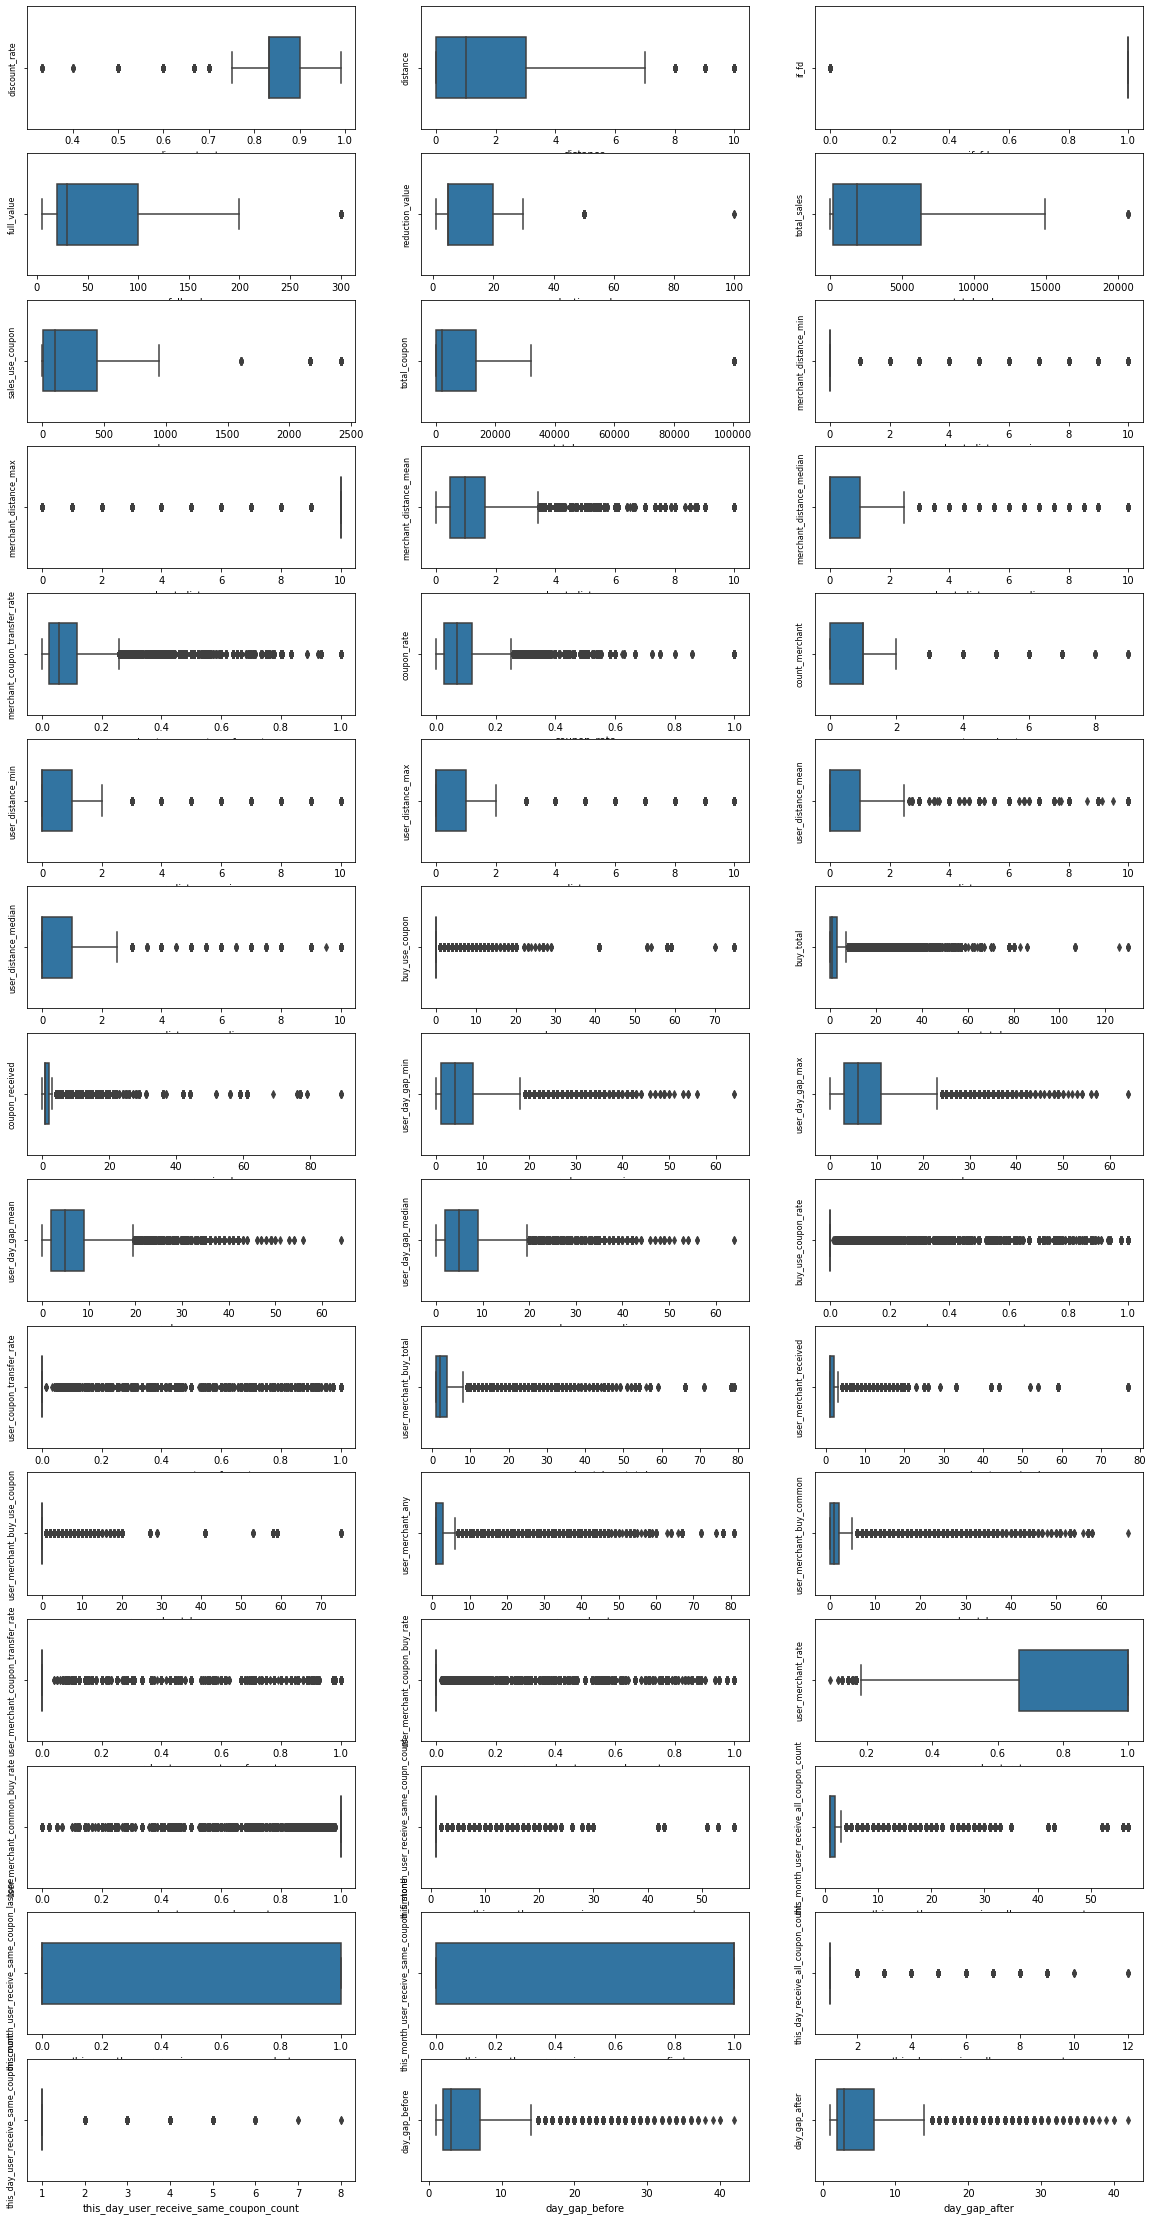

In [24]:
# 画箱式图
column = train_X.columns.tolist()[:46]  # 列表头
fig = plt.figure(figsize=(20, 40))  # 指定绘图对象宽度和高度
for i in range(45):
    plt.subplot(15, 3, i + 1)  # 15行3列子图
    sns.boxplot(train_X[column[i]], orient="v", width=0.5)  # 箱式图
    plt.ylabel(column[i], fontsize=8)
plt.show()

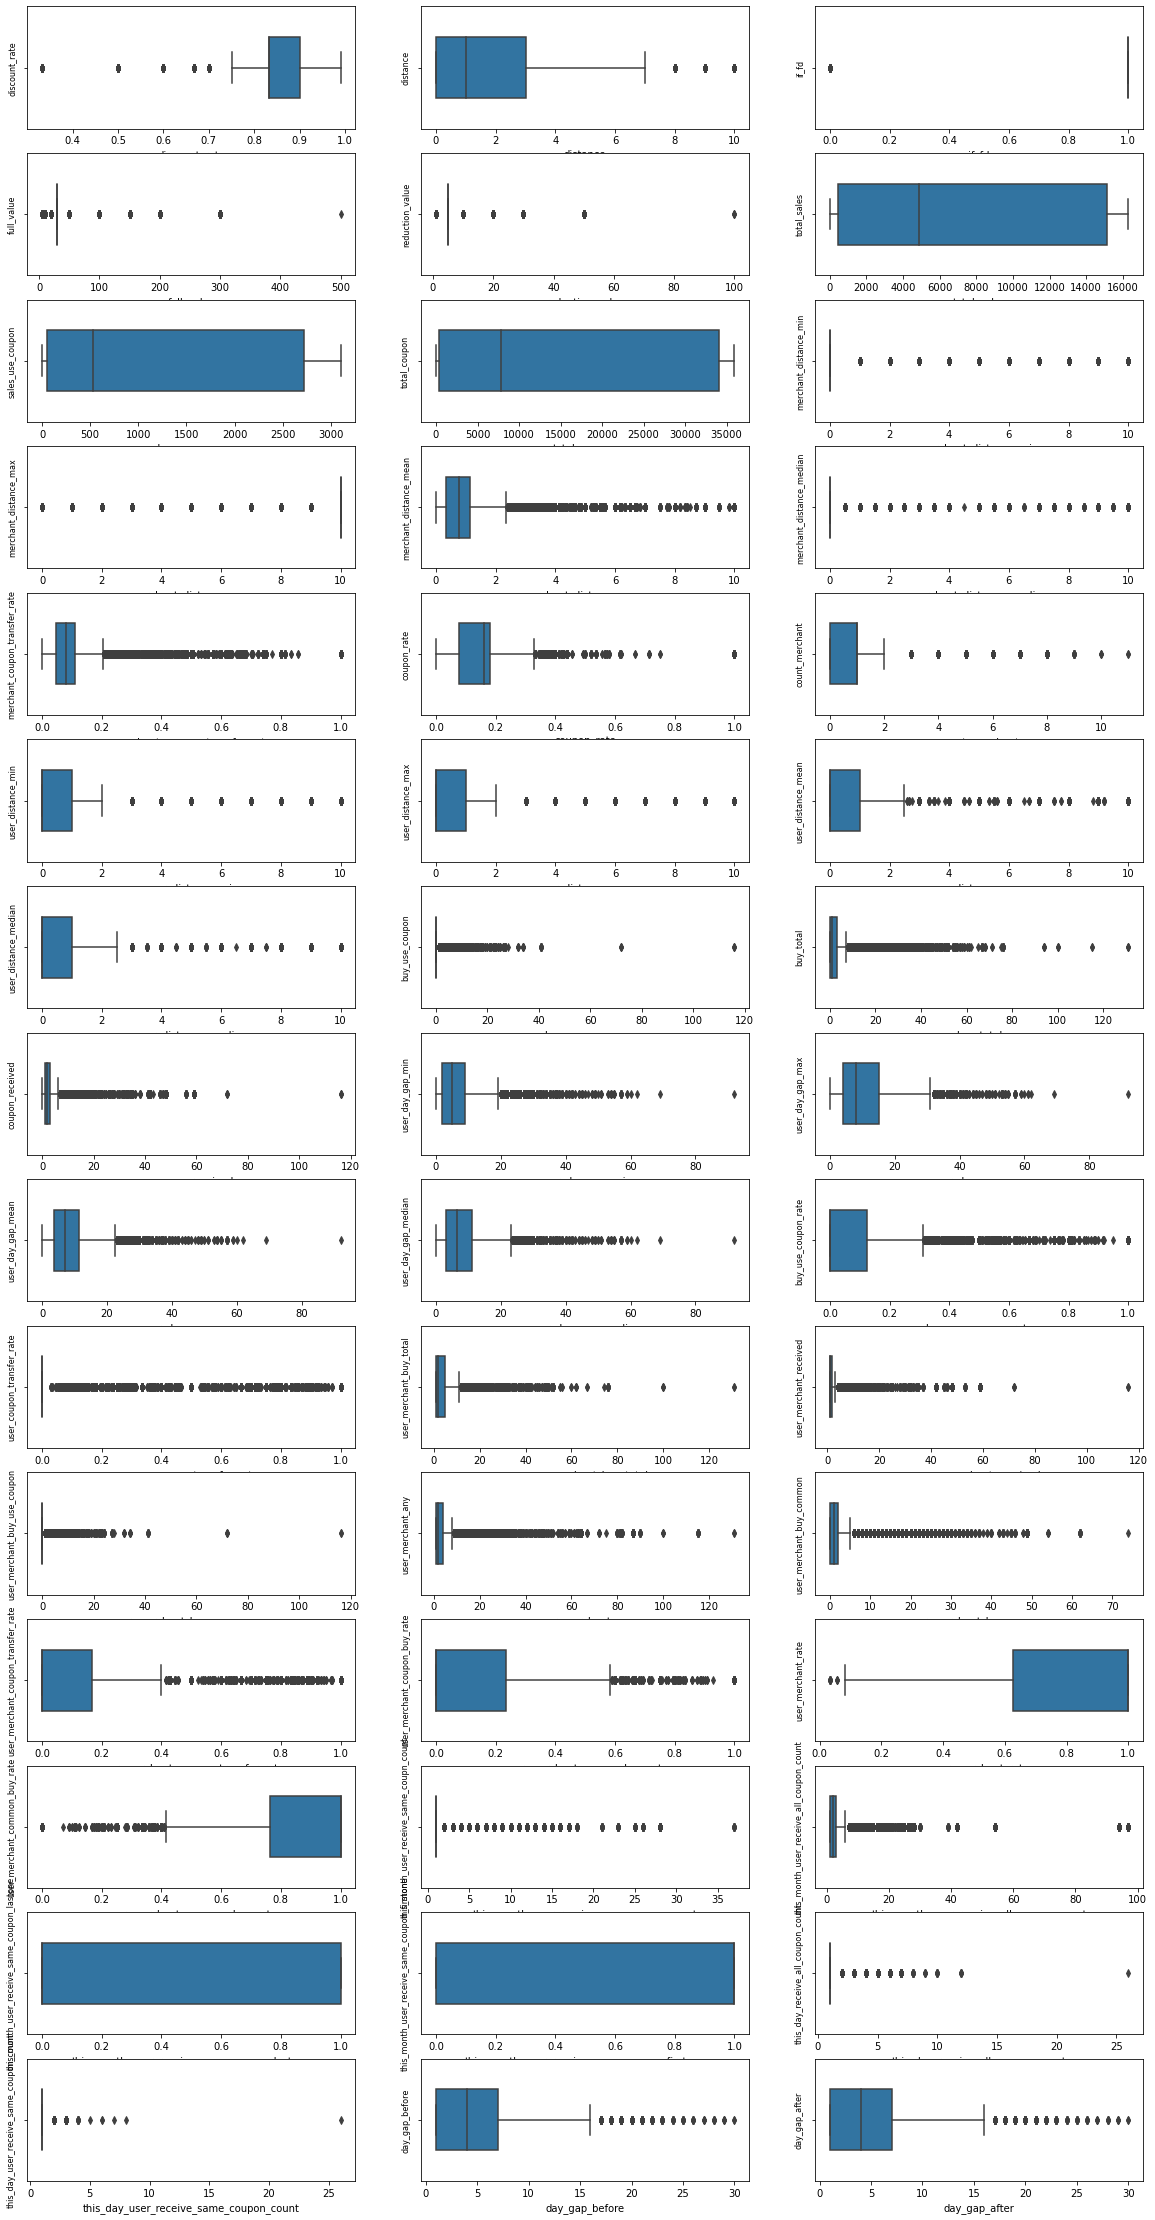

In [25]:
# 画箱式图
column = test_X.columns.tolist()[:46]  # 列表头
fig = plt.figure(figsize=(20, 40))  # 指定绘图对象宽度和高度
for i in range(45):
    plt.subplot(15, 3, i + 1)  # 15行3列子图
    sns.boxplot(test_X[column[i]], orient="v", width=0.5)  # 箱式图
    plt.ylabel(column[i], fontsize=8)
plt.show()

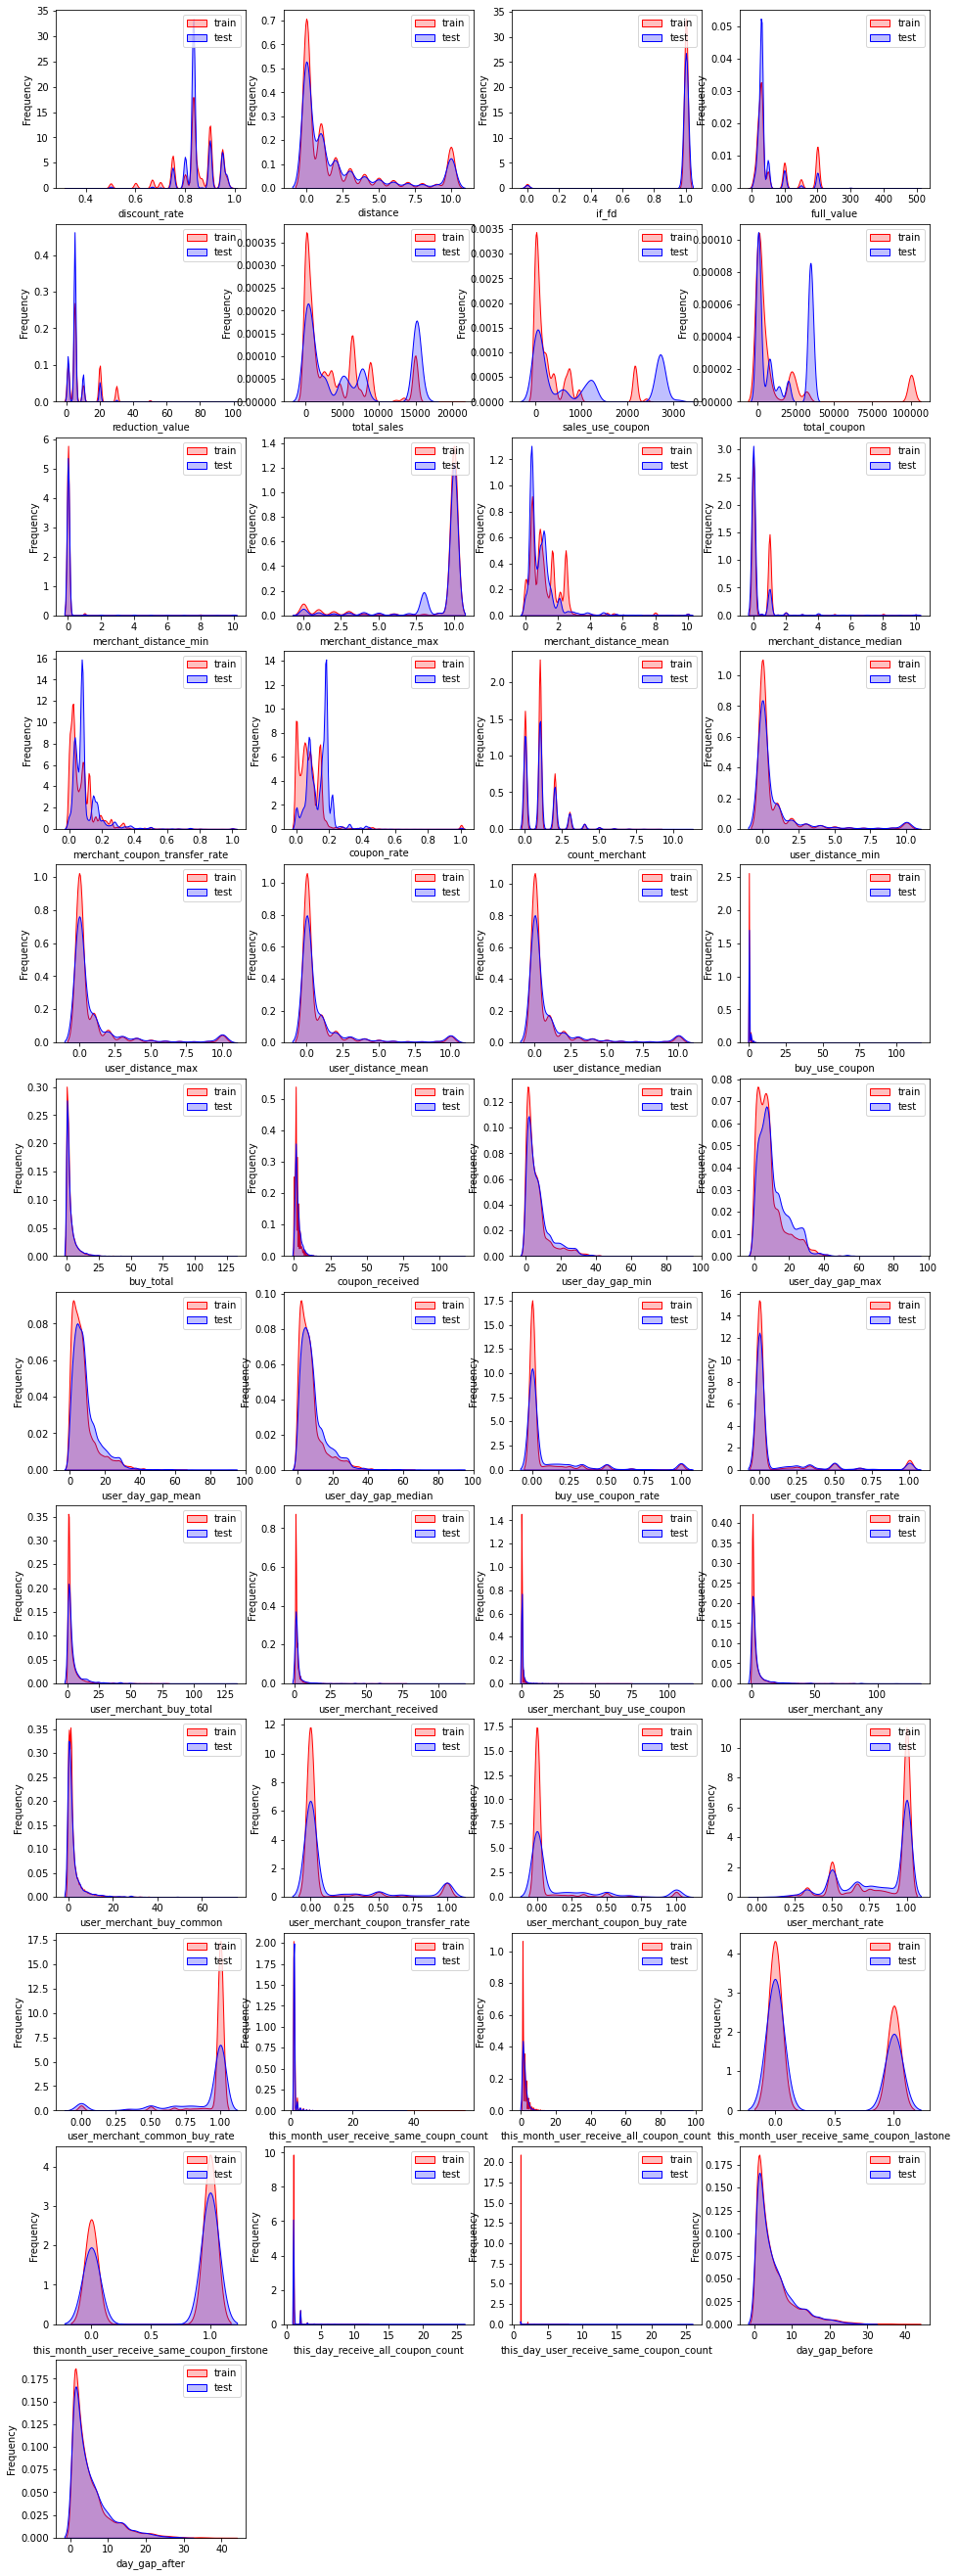

In [26]:
#对比分布
dist_cols = 4
dist_rows = len(test_X.columns)

plt.figure(figsize=(4*dist_cols,4*dist_rows))

for i, col in enumerate(test_X.columns):
    ax=plt.subplot(dist_rows,dist_cols,i+1)
    ax = sns.kdeplot(train_X[col], color="Red", shade=True)
    ax = sns.kdeplot(test_X[col], color="Blue", shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train","test"])
 
plt.show()

通过查看可以发现很多数据训练集和测试集分布不同，不过这和我们在数据探索时就已经发现测试集和训练集中是否满减情况相差很大：  
训练集满减情况  
1    0.581241  
0    0.418759  
  
测试集满减情况  
1    0.97742  
0    0.02258  
这在if_fd的那张图里面也能看到： 

因为测试集主要是满减，所以我们再对比一下训练集满减数据的分布与测试集满减数据分布的对比。 

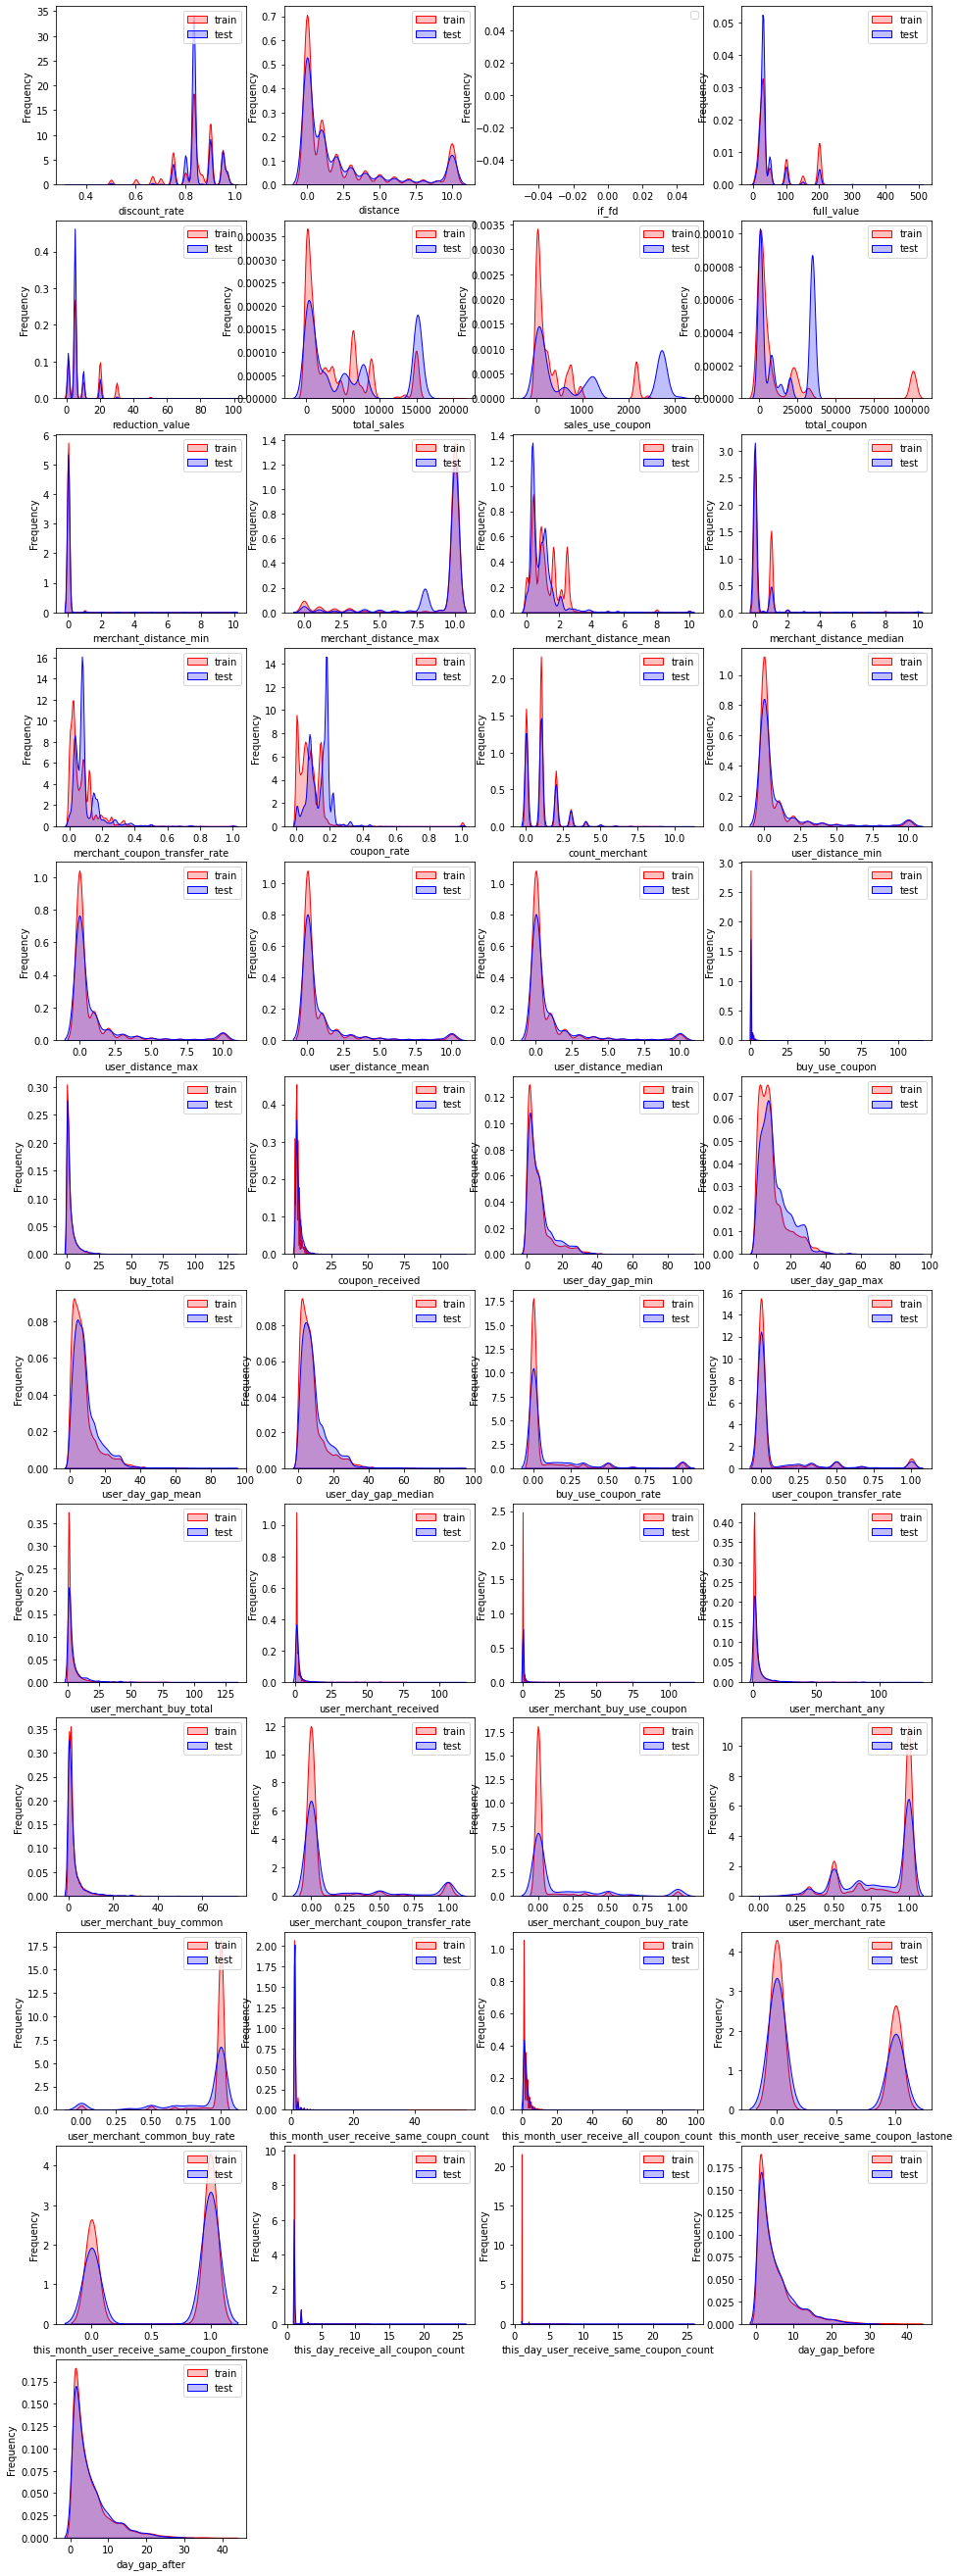

In [27]:
train_X_fd1=train_X[train_X.if_fd==1].reset_index(drop=True)
test_X_fd1=test_X[test_X.if_fd==1].reset_index(drop=True)
dist_cols = 4
dist_rows = len(test_X_fd1.columns)

plt.figure(figsize=(4*dist_cols,4*dist_rows))


for i, col in enumerate(test_X_fd1.columns):
    ax=plt.subplot(dist_rows,dist_cols,i+1)
    ax = sns.kdeplot(train_X_fd1[col], color="Red", shade=True)
    ax = sns.kdeplot(test_X_fd1[col], color="Blue", shade=True)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax = ax.legend(["train","test"])
 
plt.show()

查看后发现'sales_use_coupon', 'total_coupon', 'merchant_distance_median', 'buy_use_coupon_rate', 'user_merchant_coupon_transfer_rate'特征在训练集和测试集之间相差比较大，之外，其他的训练集和测试集分布相差不是很大。不过因为这是生成的特征，在训练集和测试集之间可能因为不同时间的商家、用户占比不同，所以造成特征分布不同。不能因为分布不同就直接删除。要在后续通过模型来选择

## 特征相关性

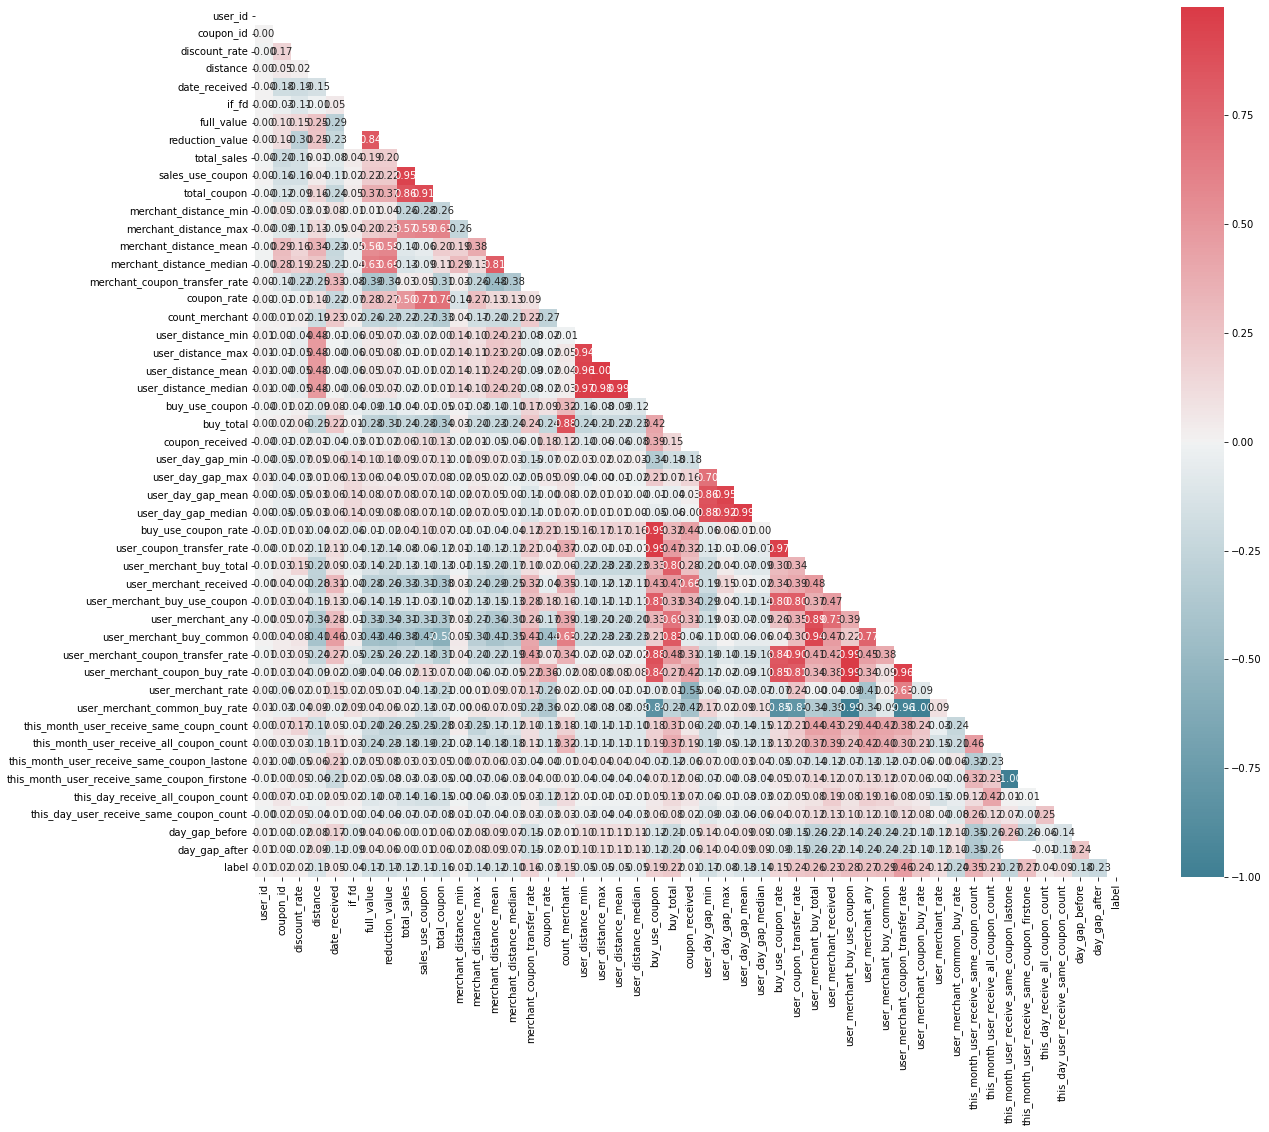

In [28]:
plt.figure(figsize=(20, 16))  
column = traindf.columns.tolist()  
mcorr = traindf[column].corr(method="spearman")  
mask = np.zeros_like(mcorr, dtype=np.bool)  
mask[np.triu_indices_from(mask)] = True  
cmap = sns.diverging_palette(220, 10, as_cmap=True)  
g = sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f')  
plt.show()

## 相关性分析

In [29]:
mcorr=mcorr.abs()
numerical_corr=mcorr[mcorr['label']>0.1]['label']
print(numerical_corr.sort_values(ascending=False))

#index0 = numerical_corr.sort_values(ascending=False).index
#print(traindf[index0].corr('spearman'))

label                                           1.000000
user_merchant_coupon_transfer_rate              0.463061
this_month_user_receive_same_coupn_count        0.350032
user_merchant_buy_common                        0.291297
user_merchant_buy_use_coupon                    0.284514
user_merchant_any                               0.267326
this_month_user_receive_same_coupon_firstone    0.265431
this_month_user_receive_same_coupon_lastone     0.265431
user_merchant_buy_total                         0.259930
user_merchant_common_buy_rate                   0.242878
user_merchant_coupon_buy_rate                   0.242878
user_coupon_transfer_rate                       0.240457
user_merchant_received                          0.233437
day_gap_after                                   0.225489
buy_total                                       0.224146
this_month_user_receive_all_coupon_count        0.208377
buy_use_coupon                                  0.186499
day_gap_before                 

可以发现几个穿越特征都排在了前面，因为它们都是在已经发生的“事实”基础上统计的，所以相关性一半会比正常的特征强。在正常的特征中，客户与某个商家之间的交互特征因为指向性很强，所以也都排在前面。

特征工程，到此结束。生成3个版本的特征：f1,sf2,sf3,后续模型的训练将主要以此为主。
没有对特征进行归一化等操作，因为对于决策树和随机森林以及XGboost算法而言，特征缩放对于它们没有什么影响，而后续主要是用LGB，XGB等算法。不过我也提供了归一化等优化的方案，大家可以运行生成新的特征，进行尝试。

# 特征后续处理

In [30]:
#特征后续处理函数
#可以根据原有特征，进行后处理。生成新的特征。
def optimize_feature(old_feature,new_feature):
    from sklearn import preprocessing 
    train_data=pd.read_csv(featurepath+'train_'+old_feature+'.csv', sep=',' , encoding = "utf-8").fillna(0)
    test_data=pd.read_csv(featurepath+'test_'+old_feature+'.csv', sep=',' , encoding = "utf-8").fillna(0)
    id_target_cols=['user_id','coupon_id','date_received','label']
    
    #归一化
    features_columns = [f for f in test_data.columns if f not in id_target_cols]
    
 
    min_max_scaler = preprocessing.MinMaxScaler()
    
    min_max_scaler = min_max_scaler.fit(train_data[features_columns])
    
    train_data_scaler = min_max_scaler.transform(train_data[features_columns])
    test_data_scaler = min_max_scaler.transform(test_data[features_columns])
    
    train_data_scaler = pd.DataFrame(train_data_scaler)
    train_data_scaler.columns = features_columns
    
    test_data_scaler = pd.DataFrame(test_data_scaler)
    test_data_scaler.columns = features_columns
    
    # 可以增加其他处理内容
    
    train_data_scaler['label'] = train_data['label']
    train_data_scaler.to_csv(featurepath+'train_s'+new_feature+'.csv',index=False,sep=',')
    test_data_scaler.to_csv(featurepath+'test_s'+new_feature+'.csv',index=False,sep=',')

#生成新版特征sf4
optimize_feature('sf3','sf4')